In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', 20)
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import re
from networkx.drawing.nx_agraph import graphviz_layout
from tqdm import tqdm
import networkx as nx

sns.reset_orig()
sys.path.append('../')

from src import CLEAN_PATENTS_PATH, CITATIONS_PATH, TAGS_PATH, DATA_PATH
from src import TEXT_EMBEDDING_PATH
from src.data import PatentsDataset, PatentsPairsDataFrame
from src.models.document_models import Doc2VecModel, BertModel
from src.models.similarities import *

INFO:transformers.file_utils:PyTorch version 1.4.0 available.


In [3]:
# Random sample for comparison
patents = PatentsDataset(CLEAN_PATENTS_PATH, 
                         from_year=2000,
                         ipc_tags_format='list',
                         clean_df=False, 
                         join_citations=False,
                         path_to_citations=CITATIONS_PATH, 
                         path_to_ipc_tags_embeddings_pkl=f'{TAGS_PATH}/sf=0.5.pkl')

INFO:root:Start reading data.
INFO:root:Read /Users/valik/LMU/patent-similarity-siemens/data/patents-clean.csv. Number of patents: 6,881,033.
INFO:root:Skip cleaning.
INFO:root:Dropped patents, older than 2000-01-01. Number of patents: 5,194,288.
INFO:root:Start reading citations.
INFO:root:Read /Users/valik/LMU/patent-similarity-siemens/data/citations-only-type-x.csv. Number of citations: 6,041,402.
INFO:root:Start creating undirected citations graph.
INFO:root:Citations graph created. Number of edges: 6,041,398. Number of nodes: 6,882,086
INFO:root:Reading ipc tags embeddings.


### Problem with duplication of abstracts (or abstracts and titles)

In [4]:
pd.set_option('display.max_colwidth', 100)
dup_ex = patents.patents[patents.patents.abstract == 'Novel polynucleotides and the proteins encoded thereby are disclosed.']\
    [['pub_number','title', 'abstract', 'ipc', 'date', 'cit_numbers_bidir_full']].head(3)
dup_ex

pub_number  \
3894836  US-2005250180-A1   
4506669  US-2003096951-A1   
4600786     WO-0175068-A3   

                                                       title  \
3894836   Secreted protein and polynucleotides encoding them   
4506669  Secreted proteins and polynucleotides encoding them   
4600786  Secreted proteins and polynucleotides encoding them   

                                                                      abstract  \
3894836  Novel polynucleotides and the proteins encoded thereby are disclosed.   
4506669  Novel polynucleotides and the proteins encoded thereby are disclosed.   
4600786  Novel polynucleotides and the proteins encoded thereby are disclosed.   

                                                                                      ipc  \
3894836                 [C12P21/06, C07K14/47, C12N15/09, A61K38/00, C12N9/00, C07H21/04]   
4506669                                                [C07K14/47, C07K14/435, A61K38/00]   
4600786  [A61K48/00, C07K14/575, C07K14/52, C07K14/475, C07K14/705, A61K38/00, C07K14/47]   

              date cit_numbers_bidir_full  
3894836 2005-11-10        [EP-2508602-A1]  
4506669 2003-05-22     [WO-2007019426-A3]  
4600786 2003-01-03        [WO-9926961-A1]

### Reading train/test pairs

In [9]:
train_pairs = PatentsPairsDataFrame(from_csv=f'{DATA_PATH}/train_pairs_1600*500.csv', name='train')

INFO:root:Reading existing pairs_df from /Users/valik/LMU/patent-similarity-siemens/data/train_pairs_1600*500.csv.
INFO:root:Read pairs_df. Number of pairs: 800000.


In [10]:
train_pairs.pairs_df.head()

pub_number_x  \
0  WO-2019030210-A1   
1  WO-2019001561-A1   
2  WO-2019001167-A1   
3     EP-3422587-A1   
4  WO-2018233691-A1   

                                                                                                 ipc_x  \
0  [C22C38/20, C23C24/10, C22C38/44, C22C38/22, B23K26/34, C22C38/42, F01D5/28, C23C30/00, B22F7/08...   
1                                                                                 [C02F9/10, B01D9/02]   
2                                                                                          [G06K17/00]   
3                                                                      [H02J7/02, H04B13/00, H04B5/00]   
4                                                           [H04W88/06, H04L1/16, H04L5/00, H04W72/04]   

      date_x  \
0 2019-02-14   
1 2019-01-03   
2 2019-01-03   
3 2019-01-02   
4 2018-12-27   

                                                                                            abstract_x  \
0  An iron-based alloy is described. Also described is a component having a surface layer 12 of an ...   
1  Disclosed are a waste water treatment system with multiple crystallizers and a waste water treat...   
2  The present application relates to a commodity shopping guide method and system based on a set t...   
3  The present invention provides a multiple-input, multiple-output (MIMO) communication apparatus ...   
4  Provided are a method and device for signal transmission and reception. The method comprises: re...   

                                                                                     title_x  \
0                                                 Alloy and component having a layer thereof   
1  Waste water treatment system with multiple crystallizers and waste water treatment method   
2     Commodity shopping guide method and system based on set top box, and electronic device   
3                        Mimo communication apparatus and method of transmitting information   
4                                    Method and device for signal transmission and reception   

     pub_number_y                             ipc_y     date_y  \
0   EP-2502729-A1            [B22F3/105, B29C67/00] 2012-09-26   
1  CN-205973859-U  [C02F101/20, C02F9/10, C02F1/04] 2017-02-22   
2  CN-105139239-A            [G06F17/30, G06Q30/06] 2015-12-09   
3   EP-1793307-A1    [H02J7/02, G06F1/26, H04B5/00] 2007-06-06   
4  CN-103618589-A              [H04L5/00, H04L1/16] 2014-03-05   

                                                                                            abstract_y  \
0  An additive layer manufacturing system (100) and method are provided. The system includes a powd...   
1  The utility model provides a handle heavy metal wastewater&#39;s vaporization system, including ...   
2  The present invention discloses a supermarket shopping system with a voice query function. The s...   
3  The electronic apparatus includes a portable electronic device and a charger for capacitively ch...   
4  The invention discloses a confirmation message transmission method and system. The method includ...   

                                                                                              title_y  \
0                                                                        Additive layer manufacturing   
1                                             Handle heavy metal wastewater&#39;s vaporization system   
2                                               Supermarket shopping system with voice query function   
3  A portable electronic device and capacitive charger providing data transfer and associated methods   
4                                                 Confirmation message transmission method and system   

   x_citation_1_hop_sim  
0                   1.0  
1                   1.0  
2                   1.0  
3                   1.0  
4                   1.0

In [14]:
# test_pairs = PatentsPairsDataFrame(patents, from_csv=f'{DATA_PATH}/test_pairs_800*500.csv', name='test')
test_pairs = PatentsPairsDataFrame(from_csv=f'{DATA_PATH}/test_pairs_800*500.csv', patents=patents,
                                   name='test')
test_pairs.number_of_possible_triplets()

INFO:root:Reading existing pairs_df from /Users/valik/LMU/patent-similarity-siemens/data/test_pairs_800*500.csv.
INFO:root:Read pairs_df. Number of pairs: 400000.
INFO:root:Calculating mean ipc textual embeddings.
../src/data/datasets.py:281: RuntimeWarning: Mean of empty slice.
  return np.array([emb for emb in map(self.ipc_embeddings_map.get, ipc_tags_list) if emb is not None]).mean(axis=0)


583089

In [6]:
test_pairs.pairs_df.head()

pub_number_x                ipc_x     date_x           abstract_x  \
0     EP-3440958-A1  [F16B12/52, A47B... 2019-02-13  A table includes...   
1  WO-2019013794-A1  [A61M1/10, A61M1... 2019-01-17  A method of dete...   
2  WO-2018233503-A1  [H04L1/18, H04W5... 2018-12-27  A communication ...   
3  WO-2018233503-A1  [H04L1/18, H04W5... 2018-12-27  A communication ...   
4  WO-2018210049-A1           [G06F3/16] 2018-11-22  An audio occupat...   

               title_x      pub_number_y                ipc_y     date_y  \
0  Motorized adjust...  WO-2015180723-A1  [A47B9/20, A47B1... 2015-12-03   
1  Hvad circadian t...  US-2017119256-A1  [A61B5/029, A61B... 2017-05-04   
2  Communication me...    CN-104144517-A  [H04L1/00, H04L1... 2014-11-12   
3  Communication me...    CN-103339995-A          [H04W56/00] 2013-10-02   
4  Audio occupation...    CN-104778041-A  [G06F3/16, G06F9... 2015-07-15   

            abstract_y              title_y  x_citation_1_hop_sim  
0  The invention re...  Supporting frame...                  1.0   
1  The present disc...  Methods and syst...                  1.0   
2  The invention pr...  Random access me...                  1.0   
3  A base-station d...  Base-station dev...                  1.0   
4  The invention di...  Management metho...                  1.0

## Basic IPC similarity
$p_1$ has $n_1$ tags $= \{tag^1_1, tag^2_1, ... tag^{n_1}_1 \}$, \
$p_2$ has $n_2$ tags $= \{tag^1_2, tag^2_2, ... tag^{n_2}_2 \}$, 

$$sim(p_1, p_2) = \frac{1}{n_1 + n_2} \Big( \sum_{i=1}^{n_1} \max_{j}\frac{\text{num_of_shared_levels}(tag^i_1, tag^j_2)}{\text{num_of_all_levels}} + \sum_{j=1}^{n_2}\max_{i}\frac{\text{num_of_shared_levels}(tag^i_1, tag^j_2)}{\text{num_of_all_levels}} \Big)$$

In [7]:
ipc_sim = BasicIPCSimilarity(levels=5)
ipc_sim.calculate_pairwise(['G06Q20/18', 'G06Q20/34', 'G07G1/14'], ['G06Q20/18', 'G06Q20/34', 'G07G1/14']), \
ipc_sim.calculate_pairwise(['G06Q20/18', 'G06Q20/34', 'G07G1/14'], ['G06Q20/34', 'G07G1/14'])

(1.0, 0.96)

In [21]:
for level_cut in range(1, 6):
    BasicIPCSimilarity(levels=level_cut).evaluate(test_pairs)

INFO:root:Calculating basic_ipc_sim1.
100%|██████████| 400000/400000 [00:42<00:00, 9429.69it/s] 
INFO:root:Calculating basic_ipc_sim2.
100%|██████████| 400000/400000 [00:42<00:00, 9447.87it/s] 
INFO:root:Calculating basic_ipc_sim3.
100%|██████████| 400000/400000 [00:42<00:00, 9516.62it/s] 
INFO:root:Calculating basic_ipc_sim4.
100%|██████████| 400000/400000 [00:56<00:00, 7096.59it/s] 
INFO:root:Calculating basic_ipc_sim5.
100%|██████████| 400000/400000 [00:42<00:00, 9416.22it/s] 


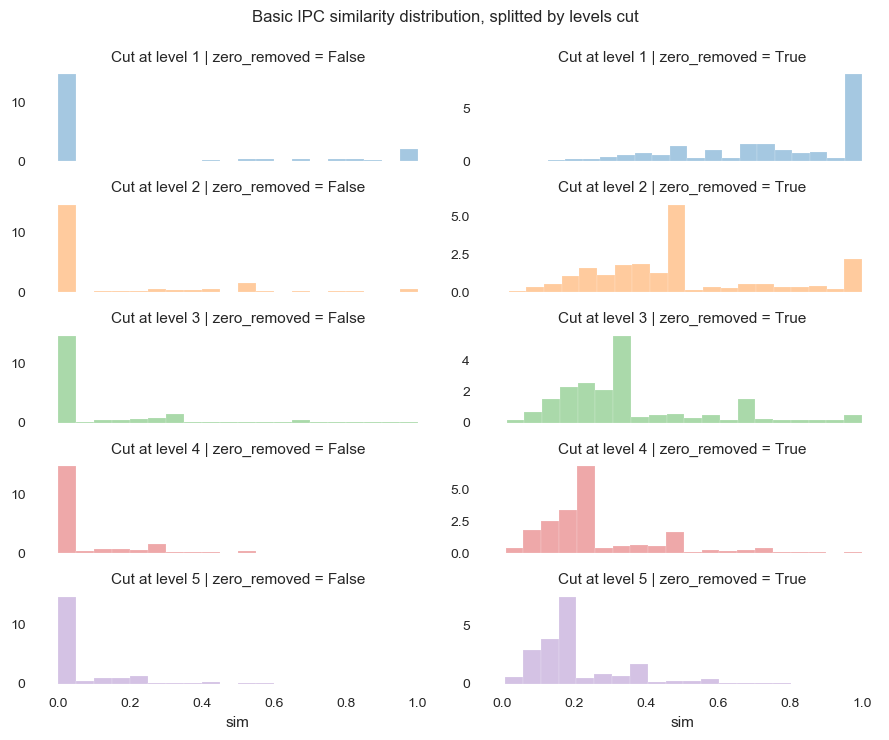

In [12]:
df = test_pairs.pairs_df.filter(regex='(basic_ipc_sim)').stack().\
        reset_index().drop(columns = 'level_0').rename(columns = {'level_1':'levels', 0: 'sim'})
df['zero_removed'] = False
df.levels = df.levels.apply(lambda s: re.findall('\d+', s)[0])
df_cropped = df[df.sim > 0.0]
df_cropped['zero_removed'] = True
df = pd.concat([df, df_cropped])


g = sns.FacetGrid(df, row="levels", hue="levels", aspect=3, height=1.5, col='zero_removed', sharey=False)
g.map(sns.distplot, "sim", bins=20, kde=False, norm_hist=True)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Basic IPC similarity distribution, splitted by levels cut')
g.set_titles(row_template = 'Cut at level {row_name}')
plt.savefig('../reports/figures/ipc_sim_dist.png', dpi = 300)
plt.show()

## IPC textual description BERT cosine similarity

In [15]:
_ = CosineSimilarity(feature='ipc_bert', load_or_calc_embeddings=False).evaluate(test_pairs)

INFO:root:Calculating ipc_bert_cosine_sim.
100%|██████████| 400000/400000 [00:36<00:00, 10929.79it/s]


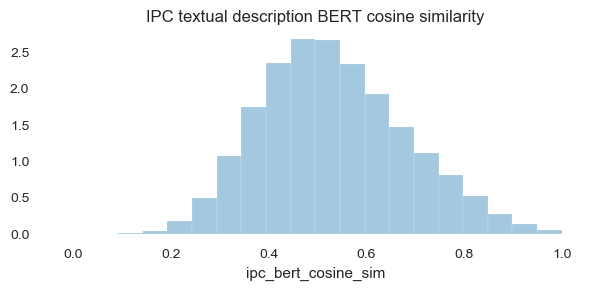

In [20]:
fig, ax = plt.subplots(figsize=(7, 3))
sns.distplot(test_pairs.pairs_df.ipc_bert_cosine_sim, bins=20, kde=False, norm_hist=True, ax=ax)
ax.set_title('IPC textual description BERT cosine similarity')
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig('../reports/figures/ipc_text_bert_dist.png', dpi = 300)
plt.show()

## Doc2Vec similarity

In [22]:
doc2vec = Doc2VecModel()

_ = CosineSimilarity(model=doc2vec, txt_feature='title').evaluate(test_pairs)
_ = CosineSimilarity(model=doc2vec, txt_feature='abstract').evaluate(test_pairs)

INFO:root:Retrieving saved Doc2Vec model...
INFO:gensim.utils:loading Doc2Vec object from /Users/valik/LMU/patent-similarity-siemens/resources/doc2vec/Doc2Vec_vs=500_e=15
INFO:gensim.utils:loading vocabulary recursively from /Users/valik/LMU/patent-similarity-siemens/resources/doc2vec/Doc2Vec_vs=500_e=15.vocabulary.* with mmap=None
INFO:gensim.utils:loading trainables recursively from /Users/valik/LMU/patent-similarity-siemens/resources/doc2vec/Doc2Vec_vs=500_e=15.trainables.* with mmap=None
INFO:gensim.utils:loading syn1neg from /Users/valik/LMU/patent-similarity-siemens/resources/doc2vec/Doc2Vec_vs=500_e=15.trainables.syn1neg.npy with mmap=None
INFO:gensim.utils:loading wv recursively from /Users/valik/LMU/patent-similarity-siemens/resources/doc2vec/Doc2Vec_vs=500_e=15.wv.* with mmap=None
INFO:gensim.utils:loading vectors from /Users/valik/LMU/patent-similarity-siemens/resources/doc2vec/Doc2Vec_vs=500_e=15.wv.vectors.npy with mmap=None
INFO:gensim.utils:loading docvecs recursively fr

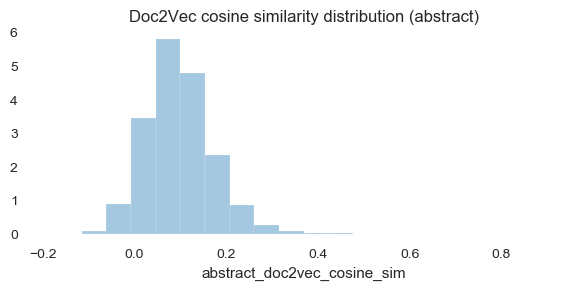

In [23]:
fig, ax = plt.subplots(figsize=(7, 3))
sns.distplot(test_pairs.pairs_df.abstract_doc2vec_cosine_sim, bins=20, kde=False, norm_hist=True, ax=ax)
ax.set_title('Doc2Vec cosine similarity distribution (abstract)')
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig('../reports/figures/doc2_vec_abstract_dist.png', dpi = 300)
plt.show()

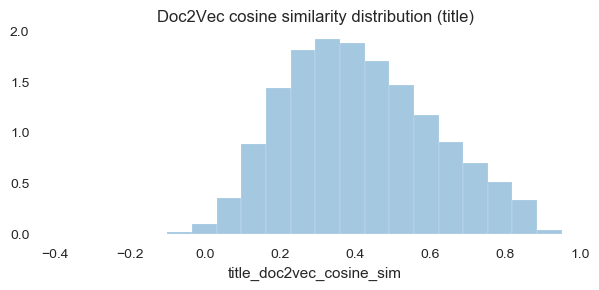

In [24]:
fig, ax = plt.subplots(figsize=(7, 3))
sns.distplot(test_pairs.pairs_df.title_doc2vec_cosine_sim, bins=20, kde=False, norm_hist=True, ax=ax)
ax.set_title('Doc2Vec cosine similarity distribution (title)')
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig('../reports/figures/doc2_vec_title_dist.png', dpi = 300)
plt.show()

## BERT similarity

In [25]:
pretrained_bert = BertModel()

_ = CosineSimilarity(model=pretrained_bert, txt_feature='title').evaluate(test_pairs)
_ = CosineSimilarity(model=pretrained_bert, txt_feature='abstract').evaluate(test_pairs)

INFO:root:Load pretrained SentenceTransformer: bert-base-nli-stsb-mean-tokens
INFO:root:Did not find a '/' or '\' in the name. Assume to download model from server.
INFO:root:Load SentenceTransformer from folder: /Users/valik/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-stsb-mean-tokens.zip
INFO:transformers.configuration_utils:loading configuration file /Users/valik/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-stsb-mean-tokens.zip/0_BERT/config.json
INFO:transformers.configuration_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },

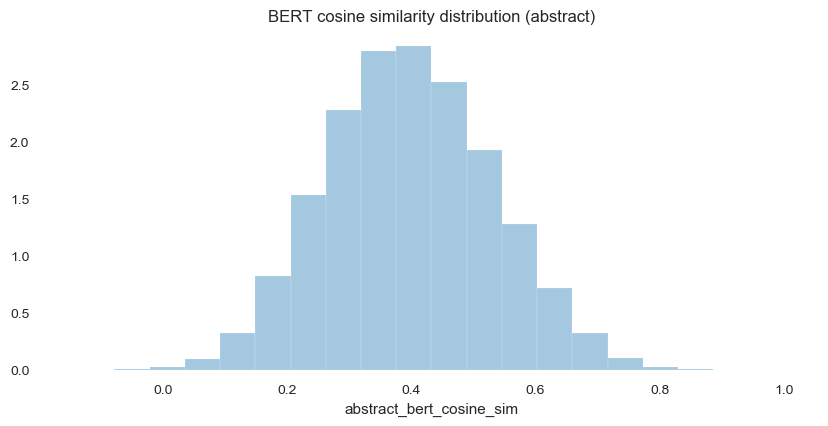

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(test_pairs.pairs_df.abstract_bert_cosine_sim, bins=20, kde=False, norm_hist=True, ax=ax)
ax.set_title('BERT cosine similarity distribution (abstract)')
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig('../reports/figures/bert_abstract_dist.png', dpi = 300)
plt.show()

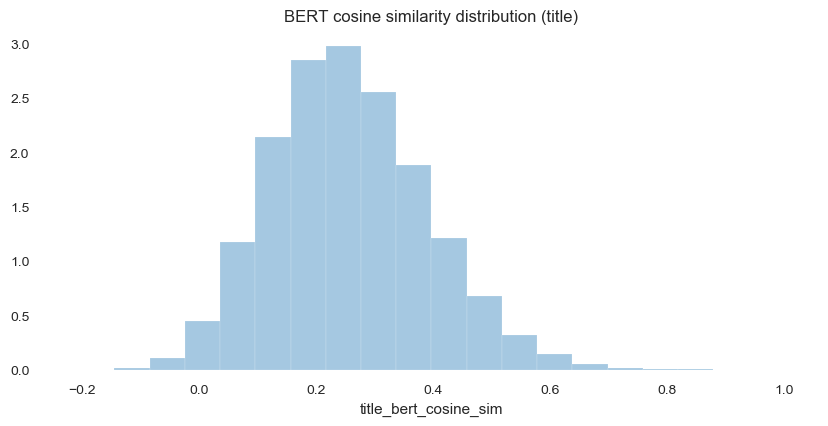

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(test_pairs.pairs_df.title_bert_cosine_sim, bins=20, kde=False, norm_hist=True, ax=ax)
ax.set_title('BERT cosine similarity distribution (title)')
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig('../reports/figures/bert_title_dist.png', dpi = 300)
plt.show()

## X-citations similarity

In [29]:
for n_hop in range(1, 2):
    BidirXCitationSimilarity(patents.citations_graph, n_hop).evaluate(test_pairs)

INFO:root:Calculating x_citation_1_hop_sim.
100%|██████████| 400000/400000 [00:18<00:00, 21998.75it/s]


In [22]:
# for col in n_hop_x_cit_sim_cols:
#     print(test_pairs.pairs_df[col].value_counts())

## Pearson correlation & mean recipocal rank

In [30]:
from src.models.metrics import mean_reciprocal_rank
sim_names = sorted(test_pairs.similarity_columns)
sns.reset_defaults()

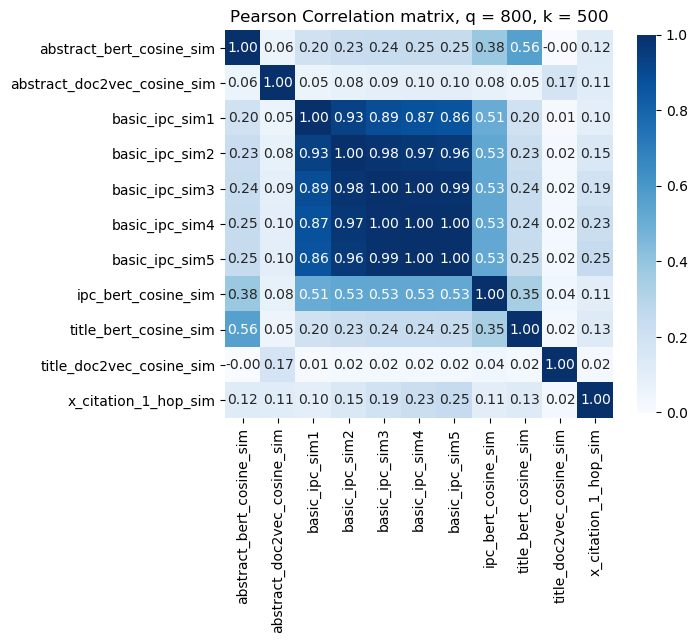

In [84]:
corr = test_pairs.pairs_df[sim_names].fillna(0.0).corr()

fig, ax = plt.subplots(figsize=(8.5, 8.5))
sns.heatmap(corr, annot=True, fmt='.2f', square=True, ax=ax, cmap='Blues', cbar_kws={"shrink": .81})
ax.set_title('Pearson Correlation matrix, q = 800, k = 500')
plt.gcf().subplots_adjust(bottom=0.33, left=0.33)
plt.savefig('../reports/figures/sim_pearson_corr.png', dpi = 300)
plt.show()

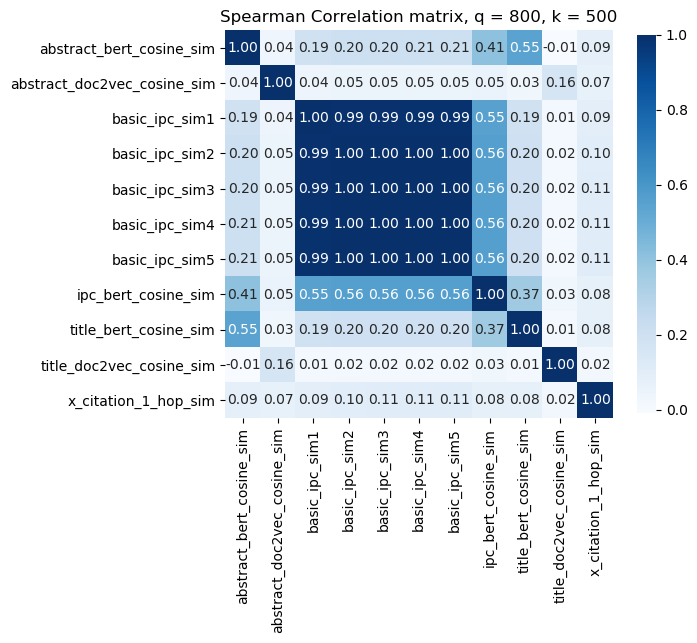

In [83]:
corr = test_pairs.pairs_df[sim_names].fillna(0.0).corr(method='spearman')

fig, ax = plt.subplots(figsize=(8.5, 8.5))
sns.heatmap(corr, annot=True, fmt='.2f', square=True, ax=ax, cmap='Blues', cbar_kws={"shrink": .81})
ax.set_title('Spearman Correlation matrix, q = 800, k = 500')
plt.gcf().subplots_adjust(bottom=0.33, left=0.33)
plt.savefig('../reports/figures/sim_spearman_corr.png', dpi = 300)
plt.show()

In [77]:
# Columns - proposed, rows - ground-truth
mrr_matrix = pd.DataFrame(data = [[mean_reciprocal_rank(test_pairs, ps, gts) for ps in sim_names] for gts in sim_names], 
                          columns=sim_names, index=sim_names)

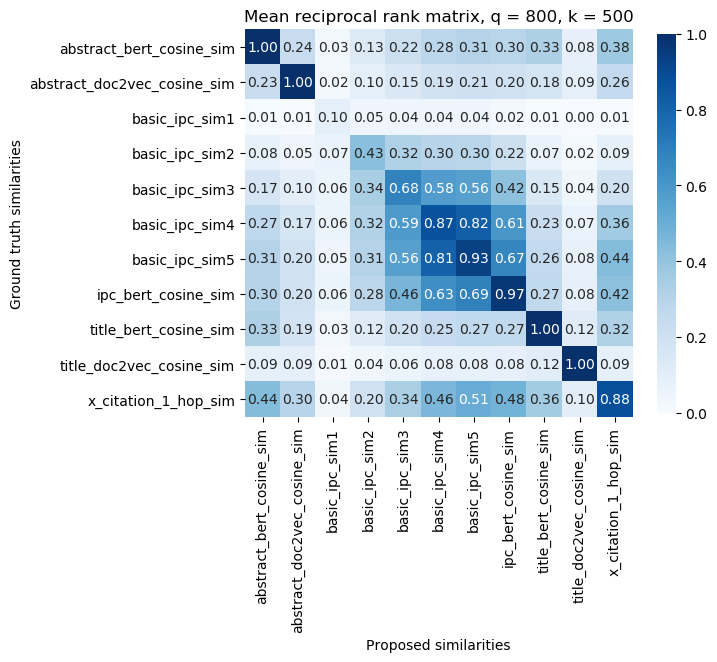

In [82]:
fig, ax = plt.subplots(figsize=(8.5, 8.5))
sns.heatmap(mrr_matrix, annot=True, vmin=0.0, vmax=1.0, fmt='.2f', square=True, ax=ax, 
            cmap='Blues', cbar_kws={"shrink": .81})
ax.set_title('Mean reciprocal rank matrix, q = 800, k = 500')
ax.set_ylabel('Ground truth similarities')
ax.set_xlabel('Proposed similarities')
plt.gcf().subplots_adjust(bottom=0.33, left=0.33)
plt.savefig('../reports/figures/sim_mrr.png', dpi = 400)
plt.show()

## Looking at random query similarities

In [79]:
rand_pairs = test_pairs.pairs_df[test_pairs.pairs_df.pub_number_x == 'WO-2019030205-A1']
pd.set_option('display.max_colwidth', 0)

In [80]:
rand_pairs[0:1][['pub_number_x','ipc_x', 'abstract_x', 'title_x']]

Empty DataFrame
Columns: [pub_number_x, ipc_x, abstract_x, title_x]
Index: []

In [30]:
rand_pairs[~rand_pairs.x_citation_1_hop_sim.isna()][['pub_number_y', 'ipc_y', 'abstract_y', 'title_y']]

pub_number_y                 ipc_y  \
0  US-2017204832-A1  [F03D1/06]             
1  EP-3176425-A1     [F03D1/06]             
2  US-2012141269-A1  [F03D7/00, F03D1/06]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      abstract_y  \
0  A wind turbine rotor blade that has a rotor blade tip, a rotor blade root, a suction side, a pressure side, a rotor blade length, a profile depth and a pitch axis of rotation. The profile depth decreases along the rotor blade length from the rotor blade root to the rotor blade tip. The trailing edge has a trailing edge delimiting line, which replicates the contour of the trailing edge. The trailing edge has a plurality of serrations to improve flow behaviour behavior at the trailing edge. The serrations respectively have a serration tip, two serration edges and an angle bisector. The serration edges are provided non-parallel to a direction of incident flow that is perpendicular to the pitch axis of rotation. The serration edges are non-perpendicular to a tangent to the trailing edge delimiting line. The trailing edge delimiting line has a plurality of portions, at least one of the portions extending non-parallel to the pitch axis of rotation.                                                                    
1  An assembly is provided of, firstly, an aerofoil-shaped body, such as a wing of an airplane or a rotor blade of a wind turbine, having a trailing edge and, secondly, a noise reducing serration extending along at least part of said trailing edge. The serration comprises a base plate defining a first edge connected to the aerofoil-shaped body near to said trailing edge and a second edge having attached thereto a number of teeth defining tips facing away from the base plate. The base plate is located behind the trailing edge and is separated therefrom by a gap wherein the connection between the base plate and aerofoil-shaped body is defined by at least one tape-like member made of a material which allows the tape-like member to bend, stretch and buckle. The serration in such a manner is stiff against bending but weak against torsion that in a range of expected operational loads the serration is not able to bend substantially, whereas in said range of expected operational loads the base plate is able to twist.   
2  A rotor blade assembly for a wind turbine and a method for increasing a loading capability of a rotor blade within a maximum load limit for a wind turbine are disclosed. The rotor blade assembly includes a rotor blade having surfaces defining a pressure side, a suction side, a leading edge, and a trailing edge extending between a tip and a root. The rotor blade assembly further includes an extension connected to a surface of the rotor blade, the extension having at least one design characteristic configured for increasing a loading capability of the rotor blade within a maximum load limit for the wind turbine. The design characteristic is one of extension length, extension width, extension curvature, span-wise extension location,

In [ ]:
rand_pairs.sort_values('abstract_bert_cosine_sim', ascending=False).head()[['pub_number_y', 'ipc_y', 'abstract_y', 'title_y']]

In [ ]:
rand_pairs.sort_values('abstract_doc2vec_cosine_sim', ascending=False).head()[['pub_number_y', 'ipc_y', 'abstract_y', 'title_y']]

In [ ]:
rand_pairs.sort_values('abstract_doc2vec_cosine_sim', ascending=False).head()[['pub_number_y', 'ipc_y', 'abstract_y', 'title_y']]

pub_number_y                                      ipc_y  \
2     US-2012141269-A1  [F03D7/00, F03D1/06]                        
1299  CN-101302998-A    [F03D80/70, F03D9/25, F03D3/04, F03D3/06]   
1460  WO-2006099104-A2  [F01C1/08]                                  
1511  CN-107965546-A    [F16F9/53, F16F15/00]                       
0     US-2017204832-A1  [F03D1/06]                                  

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     abstract_y  \
2     A rotor blade assembly for a wind turbine and a method for increasing a loading capability of a rotor blade within a maximum load limit for a wind turbine are disclosed. The rotor blade assembly includes a rotor blade having surfaces defining a pressure side, a suction side, a leading edge, and a trailing edge extending between a tip and a root. The rotor blade assembly further includes an extension connected to a surface of the rotor blade, the extension having at least one design characteristic configured for increasing a loading capability of the rotor blade within a maximum load limit for the wind turbine. The design characteristic is one of extension length, extension width, extension curvature, span-wise extension location, chord-wise extension location, or extension angle with respect to a chord line of the rotor blade.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
1299  The invention discloses a multi-wind-direction accelerating aerogenerator, pertaining to the technical field of the aerogenerator. The structure of the aerogenerator comprises a rotating vane, the shaft of which is arranged vertically and the top of which is connected with a generator shaft, and rotating vane blades are evenly distributed on the exterior of the rotating vane shaft and arranged vertically. The aerogenerator is characterized in that: fixed vane blades are evenly distributed around the rotating vane by taking the rotating vane shaft as the axes and arranged vertically, externally wide and internally narrow diversion air passages are formed between the neighboring fixed vane blades; no steering mechanism is needed and full utilization of wind energy can be realized; the structure is simple, the implementation is easy and the cost is low; whatever the wind direction is, 

In [32]:
rand_pairs.sort_values('abstract_doc2vec_cosine_sim', ascending=False).head()[['pub_number_y', 'ipc_y', 'abstract_y', 'title_y']]

pub_number_y  \
0     US-2017204832-A1   
2     US-2012141269-A1   
1711  EP-1562704-A1      
1329  CN-105793223-A     
1301  EP-2465493-A1      

                                                                                                ipc_y  \
0     [F03D1/06]                                                                                        
2     [F03D7/00, F03D1/06]                                                                              
1711  [B01J31/02, B01J31/22, B01J31/04, C08G63/85]                                                      
1329  [C07C39/30, C07C37/84, C07C37/74]                                                                 
1301  [A61K47/10, A61K47/18, A61Q19/00, A61K9/00, A61K8/42, A61K47/26, A61K8/34, A61K47/32, A61K8/60]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        abstract_y  \
0     A wind turbine rotor blade that has a rotor blade tip, a rotor blade root, a suction side, a pressure side, a rotor blade length, a profile depth and a pitch axis of rotation. The profile depth decreases along the rotor blade length from the rotor blade root to the rotor blade tip. The trailing edge has a trailing edge delimiting line, which replicates the contour of the trailing edge. The trailing edge has a plurality of serrations to improve flow behaviour behavior at the trailing edge. The serrations respectively have a serration tip, two serration edges and an angle bisector. The serration edges are provided non-parallel to a direction of incident flow that is perpendicular to the pitch axis of rotation. The serration edges are non-perpendicular to a tangent to the trailing edge delimiting line. The trailing edge delimiting line has a plurality of portions, at least one of the portions extending non-parallel to the pitch axis of rotation.   
2     A rotor blade assembly for a wind turbine and a method for increasing a loading capability of a rotor blade within a maximum load limit for a wind turbine are disclosed. The rotor blade assembly includes a rotor blade having surfaces defining a pressure side, a suction side, a leading edge, and a trailing edge extending between a tip and a root. The rotor blade assembly further includes an extension connected to a surface of the rotor blade, the extension having at least one design characteristic configured for increasing a loading capability of the rotor blade within a maximum load limit for the wind turbine. The design characteristic is one of extension length, extension width, extension curvature, span-wise extension location, chord-wise extension location, or extension angle with respect to a chord line of the rotor blade.                                                                                                                         
1711  A catalyst composition prepared from (a) titanium tetrahydrocarbyloxide, (b) zirconium tetrahydrocarbyloxide, and (c) tetraalkyl ammonium hydroxide, wherein the molar ratio of Zr:Ti is from about 0.02:1 to about 5:1 and the molar ratio of TAAH:(Ti+Zr) is from about 0.05:1 to about 2:1.                                